# Project 3 - Face Morphing
Romil Bhardwaj

Before running this notebook, please annotate your faces using annotate.py

In [5]:
import csv
import numpy as np
import pandas as pd
import skimage.io as skio
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.spatial.qhull import Delaunay
from skimage.draw import draw
import os
import time

## Face Morphing Video

In [59]:
def get_affine_transform(tri1_pts, tri2_pts):
    m1 = np.array([tri1_pts[:,0], tri1_pts[:, 1], np.ones(3)])
    m2 = np.array([tri2_pts[:,0], tri2_pts[:, 1], np.ones(3)])
    return np.matmul(m2, np.linalg.inv(m1))

def masked_affine_tranform(im, mask, affine_transform):
    affine_0, affine_1, _ = np.matmul(np.linalg.inv(affine_transform), mask).astype(np.int)
    mask_0, mask_1, _ = mask.astype(np.int)
    result = np.zeros_like(im)
    result[mask_1, mask_0] = im[affine_1, affine_0]
    return result

def read_keypoints(csv_path):
    with open(csv_path, 'r') as f:
        return np.array([list(map(float,rec)) for rec in csv.reader(f, delimiter=',')])

def read_img_and_keypoints(img_path):
    img = skio.imread(img_path)
    
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    csv_path = os.path.join(os.path.dirname(img_path), f'{img_filename}.csv')
    
    keypoints = read_keypoints(csv_path)
    return img, keypoints

def get_triangle_mask(triangle, image_shape):
    points = draw.polygon(triangle[:,0], triangle[:,1], shape=(image_shape[1], image_shape[0], image_shape[2]))
    return np.vstack([points, np.ones(len(points[0]))])

def morph(im1, im2, pts1, pts2, triangles, warp_frac, dissolve_frac):
    avg_points = (dissolve_frac * pts1 + (1 - dissolve_frac) * pts2)
    result_img = np.zeros_like(im1, dtype=np.float)
    for t in triangles:
        mask = get_triangle_mask(avg_points[t], im1.shape)
        affine_tranform1 = get_affine_transform(pts1[t], avg_points[t])
        affine_tranform2 = get_affine_transform(pts2[t], avg_points[t])
        result_img += (warp_frac * masked_affine_tranform(im1, mask, affine_tranform1) + (1-warp_frac) * masked_affine_tranform(im2, mask, affine_tranform2)) / 255
    return result_img

def create_morph_vid(im1, im2, pts1, pts2, num_keyframes, out_path, loop_count=3):
    triangles = Delaunay(pts1).simplices
    warp_fracs = np.linspace(0,1,num_keyframes)
    dissolve_fracs = np.linspace(0,1,num_keyframes)
    frames = []
    fig = plt.figure()
    for warp_frac, dissolve_frac in zip(warp_fracs, dissolve_fracs):
        morphed_im = morph(im1, im2, pts1, pts2, triangles, warp_frac, dissolve_frac)
        mplframe = plt.imshow(morphed_im)
        plt.tight_layout()
        frames.append([mplframe])
    
    # Create reversed frames and loop loop_count times
    write_frames = (frames + list(reversed(frames)))*loop_count
    
    #fig.set_size_inches(int(im1.shape[1]/50), int(im1.shape[0]/50), 10)
    vid = animation.ArtistAnimation(fig, write_frames, interval=100000, repeat=False)
    vid.save(out_path, writer=animation.writers['ffmpeg'](fps=5))
    
    # Save midway face
    out_filename = os.path.splitext(os.path.basename(out_path))[0]
    midwayim_path = os.path.join(os.path.dirname(out_path), f'{out_filename}_midway.jpg')
    midway_img = morph(im1, im2, pts1, pts2, triangles, warp_frac=0.5, dissolve_frac=0.5)
    skio.imsave(midwayim_path, midway_img)
    

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


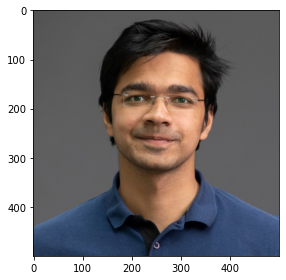

In [60]:
im1_path = 'imgs/jamesmay.jpg'
im2_path = 'imgs/romil.jpg'
im1, pts1 = read_img_and_keypoints(im1_path)
im2, pts2 = read_img_and_keypoints(im2_path)
create_morph_vid(im1, im2, pts1, pts2, 10, 'out.mp4')

## Mean Face of a population


In [40]:
def get_points_asf(file_name):
    lines = asf_reader.read_asf(file_name)
    points = []
    for line in lines:
        data = line.split(" \t")
        points.append((float(data[2]), float(data[3])))
    points.append((0., 0.))
    points.append((1., 0.))
    points.append((0., 1.))
    points.append((1., 1.))
    return np.array(points)

def read_db(path, regex_img):
    file_ls = []
    points_ls = []
    for file in os.listdir(path):
       if re.match(regex_img, file):
           img = io.imread(os.path.join(path, file))
           file_ls.append(img)
           asf_file = re.sub("jpg", "asf", os.path.join(path, file))
           points_ls.append(get_points_asf(asf_file))

    shape = file_ls[0].shape
    for point_set in points_ls:
        for i in range(0, len(point_set)):
            point_set[i] = (point_set[i][0]*shape[1], point_set[i][1]*shape[0])

    return file_ls, points_ls


## Blend population
def create_population_blend(tri_list, images, point_sets):
    avg = avg_population_points(point_sets)
    final = np.zeros_like(images[0]).astype(np.float)
    for tri in tri_list:
        target_tri = avg[tri]
        target_mask = triangle_bool_matrix(target_tri, images[0].shape)
        for i in range(0, len(images)):
            src_tri = np.array(point_sets[i])[tri]
            final_tri = (1/len(images)) * apply_masked_affine(target_mask, images[i],
                                                              src_tri, target_tri) / 255
            final += final_tri
    final[final > 1] = 1
    return final, avg


## Save population mean face
def compute_pop_mean_face(path, regex, dest_img):
    images, points = read_db(path, regex)
    delu = Delaunay(points[0])
    triangles = delu.simplices
    final, avg_points = create_population_blend(triangles, images, points)
    io.imsave(dest_img, final)
    pickle_name = re.split("\.", dest_img)[0] + ".p"
    pickle.dump(list(avg_points), open(pickle_name, "wb"))

def read_danes_dataset(dataset_root):
    # Get list of jpgs, return imgs and keypoints
    pass

def read_danes_img_and_keypoints(img_path):
    img = skio.imread(img_path)
    
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    asf_path = os.path.join(os.path.dirname(img_path), f'{img_filename}.asf')
    df = pd.read_csv(asf_path, header=None, skiprows=16, nrows=58, delimiter='\t')
    keypoints_relative = df[[2,3]]
    keypoints_absolute = keypoints_relative.copy()
    keypoints_absolute[2] = keypoints_absolute[2]*img.shape[1]
    keypoints_absolute[3] = keypoints_absolute[3]*img.shape[0]
    keypoints_absolute = np.array(keypoints_absolute)
    
    return img, keypoints_absolute, keypoints_relative

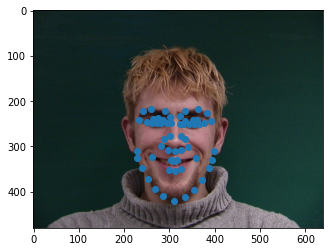

In [44]:
# Test dataset reading
img, kps, kp2 = read_danes_img_and_keypoints('imm_face/01-2m.jpg')
plt.imshow(img)
plt.scatter(x=kps[:,0], y=kps[:,1])

array([[227.5967808, 309.5091552],
       [228.8870976, 326.277696 ],
       [238.564512 , 348.2058048],
       [253.4032256, 372.0687408],
       [267.5967808, 393.9968496],
       [285.6612992, 410.1204576],
       [309.5322624, 419.794608 ],
       [334.048384 , 412.0552848],
       [354.048384 , 395.2867392],
       [371.467744 , 373.3586304],
       [386.9515968, 348.2058048],
       [393.4032448, 329.5024128],
       [397.274208 , 310.7990448],
       [375.3387072, 248.2394304],
       [361.7903168, 240.5001072],
       [352.1128832, 240.5001072],
       [335.3387072, 243.724824 ],
       [329.5322432, 249.5293248],
       [343.0806336, 249.5293248],
       [354.693568 , 250.1742816],
       [365.0161344, 250.1742816],
       [251.467744 , 246.9495408],
       [263.7257984, 238.5652704],
       [274.6935488, 237.2753904],
       [285.0161344, 241.1450688],
       [294.048384 , 248.884392 ],
       [282.4354752, 248.884392 ],
       [272.7580672, 247.5944976],
       [260.4999936,